In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy

from z3 import *
import grilops
import grilops.regions

In [2]:
# Back to the first problem. Redoing withh Z3
url='https://www.janestreet.com/puzzles/its-symmetric/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
print("Puzzle")
print("~~~~~~")
print(" ".join(y[8:10]))

Puzzle
~~~~~~
(A few examples: In a 1-by-N region, all cells could be labeled 0, since a reflection across the longer mid-line takes every cell to itself. In the “S”-shaped Tetris piece, the cells could be labeled 3, 1, 1, 3.) The answer to this puzzle is the


### Puzzle details
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2018/03/20180301_symmetric.png" width="350" >


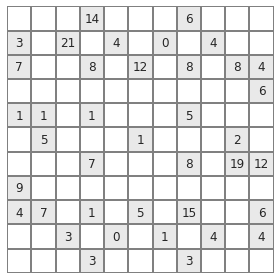

In [3]:
givens = np.array([[-1, -1, -1, 14, -1, -1, -1,  6, -1, -1, -1],
                   [ 3, -1, 21, -1,  4, -1,  0, -1,  4, -1, -1],
                   [ 7, -1, -1,  8, -1, 12, -1,  8, -1,  8,  4],
                   [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  6],
                   [ 1,  1, -1,  1, -1, -1, -1,  5, -1, -1, -1],
                   [-1,  5, -1, -1, -1,  1, -1, -1, -1,  2, -1],
                   [-1, -1, -1,  7, -1, -1, -1,  8, -1, 19, 12],
                   [ 9, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                   [ 4,  7, -1,  1, -1,  5, -1, 15, -1, -1,  6],
                   [-1, -1,  3, -1,  0, -1,  1, -1,  4, -1,  4],
                   [-1, -1, -1,  3, -1, -1, -1,  3, -1, -1, -1]])

fig,ax = plt.subplots(1,1,figsize=(4,4))
x = np.array((givens).astype('int').astype('str'))
x[x=="-1"] =""
ax =sns.heatmap(givens!=-1,annot=x,cbar=False,center=3,cmap="Greys",fmt="",linewidths=1,linecolor="grey",annot_kws={"size":12})
ax.axis("off")
plt.tight_layout()

In [4]:
givens=np.array([[-1,-1, 4, 9],
                 [-1,-1, 0,-1],
                 [-1, 2,-1,-1],
                 [ 3, 1,-1,-1]])


In [5]:
N= givens.shape[0]

# longhand in z3py
def neigbours(grid, i, j):     
    l = []
    (rows,cols) = grid.shape
    if i-1 >= 0:
            l.append((i-1,j))
    if i+1 < rows:
            l.append((i+1,j))
    if j-1 >= 0:
            l.append((i,j-1))
    if j+1 < cols:
            l.append((i,j+1))
    return l

Solved in 0.13 seconds


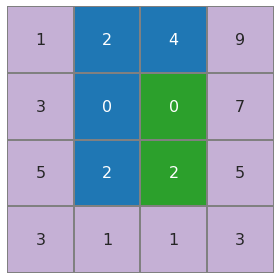

In [14]:
start = time.time()    
s = Solver()

# Directed edges
edge = {}
for i in range(N):
    for j in range(N):  
        for (k,l) in neigbours(givens,i,j) :
            edge[(i,j,k,l)] = Int("e%d%d%d%d" % (i,j,k,l))
            s += Or(edge[(i,j,k,l)] ==0,edge[(i,j,k,l)]==1) 
            
# Define a variable to determine if there is an edge between 2 cells
for i in range(N):
    for j in range(N):  
        for (k,l) in neigbours(givens,i,j):
            s += (edge[(i,j,k,l)] + edge[(k,l,i,j)]) <= 1
    
# Make edges one way to form a tree
for i in range(N):
    for j in range(N):  
        s += Sum([edge[(k,l,i,j)] for (k,l) in neigbours(givens,i,j) ]) <=1    

# Set up a variable for the number in a cell  
X = [[Int("x%d%d" % (i,j)) for j in range (N) ] for i in range (N) ] 
s += [And(X[i][j]>= 0,X[i][j]<=21) for i in range(N) for j in range(N)]

# Place the fixed cells
for i in range(N):
    for j in range(N):  
        if givens[i,j] > -1:
            s += X[i][j] == int(givens[i,j])  
            
# Set up a variable for the size of the tree at each point       
size = [[Int("s%d%d" % (i,j)) for j in range (N) ] for i in range (N) ]

# Calculate size of cell as 1 + the cells it feeds into
for i in range(N):
    for j in range(N):   
        s +=  size[i][j] == Sum([If(edge[(i,j,k,l)]==1,size[k][l],0) for (k,l) in neigbours(givens,i,j)])+1
        
# For roots (cells with no cells feeding in) size of cell must be equal to number in cell
for i in range(N):
    for j in range(N):  
        s+= Implies(Sum([edge[(k,l,i,j)] for (k,l) in neigbours(givens,i,j)]) == 0 ,size[i][j]> X[i][j])      
    
# Cells with an edge have the same value
for i in range (N) :
    for j in range (N) : 
        for (k,l) in neigbours(givens,i,j) :
            s +=Implies(edge[(i,j,k,l)] == 1,Or(X[i][j] == X[k][l]-2,X[i][j]-2 == X[k][l],And(X[i][j] ==1, X[k][l]==1)))
    
# Variables for the root of each tree
root = [[Int("r%d%d" % (i,j)) for j in range (N) ] for i in range (N) ]

# Define the areas based on the root of the tree
for i in range(N):
    for j in range(N):  
        s+= Implies(Sum([edge[(k,l,i,j)] for (k,l) in neigbours(givens,i,j)]) == 0 ,root[i][j]==i*N+j)      
        
# Neighboring cells with same number must be in same area        
for i in range (N) :
    for j in range (N) : 
        for (k,l) in neigbours(givens,i,j) :
            s +=Implies(edge[(k,l,i,j)] ==1,root[i][j]==root[k][l])    
        
if s.check() == sat:
    print("Solved in {:.2f} seconds".format(time.time()-start))
    m = s.model()
    r = [ [ m.evaluate(X[i][j]).as_long() for j in range(N) ] for i in range(N) ]
    roots = [ [ m.evaluate(root[i][j]).as_long() for j in range(N) ] for i in range(N) ]
    fig,ax = plt.subplots(1,1,figsize=(4,4))
    ax =sns.heatmap(np.array(roots),annot=np.array(r),cbar=False,center=3,cmap="tab20_r",fmt="",linewidths=1,linecolor="grey",annot_kws={"size":16})
    ax.axis("off")
    plt.tight_layout()
    plt.show()
    
else:
    print("failed to solve")

In [10]:
url='https://www.janestreet.com/puzzles/solutions/march-2018-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print("Solution")
print("~~~~~~~~")
print(" ".join(x[7:10]))

Solution
~~~~~~~~
The completed grid is presented here, and the sum of the cubes of the areas of the different regions is 33,679 .  Congrats to everyone who solved this month’s puzzle!


### Solution
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2018/04/Mar18_solution.png" width="400">


In [8]:
np.ones((11,11),dtype=int)*-1

array([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])